In [72]:
!pip install imblearn


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [37]:
# Loading dataset into a data frame
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_excel(r'C:\Users\Omar Issa\Desktop\titanic3.xls')

print(df.head())
print(df.info())

   pclass  survived                                             name     sex  \
0       1         1                    Allen, Miss. Elisabeth Walton  female   
1       1         1                   Allison, Master. Hudson Trevor    male   
2       1         0                     Allison, Miss. Helen Loraine  female   
3       1         0             Allison, Mr. Hudson Joshua Creighton    male   
4       1         0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female   

       age  sibsp  parch  ticket      fare    cabin embarked boat   body  \
0  29.0000      0      0   24160  211.3375       B5        S    2    NaN   
1   0.9167      1      2  113781  151.5500  C22 C26        S   11    NaN   
2   2.0000      1      2  113781  151.5500  C22 C26        S  NaN    NaN   
3  30.0000      1      2  113781  151.5500  C22 C26        S  NaN  135.0   
4  25.0000      1      2  113781  151.5500  C22 C26        S  NaN    NaN   

                         home.dest  
0                     St 

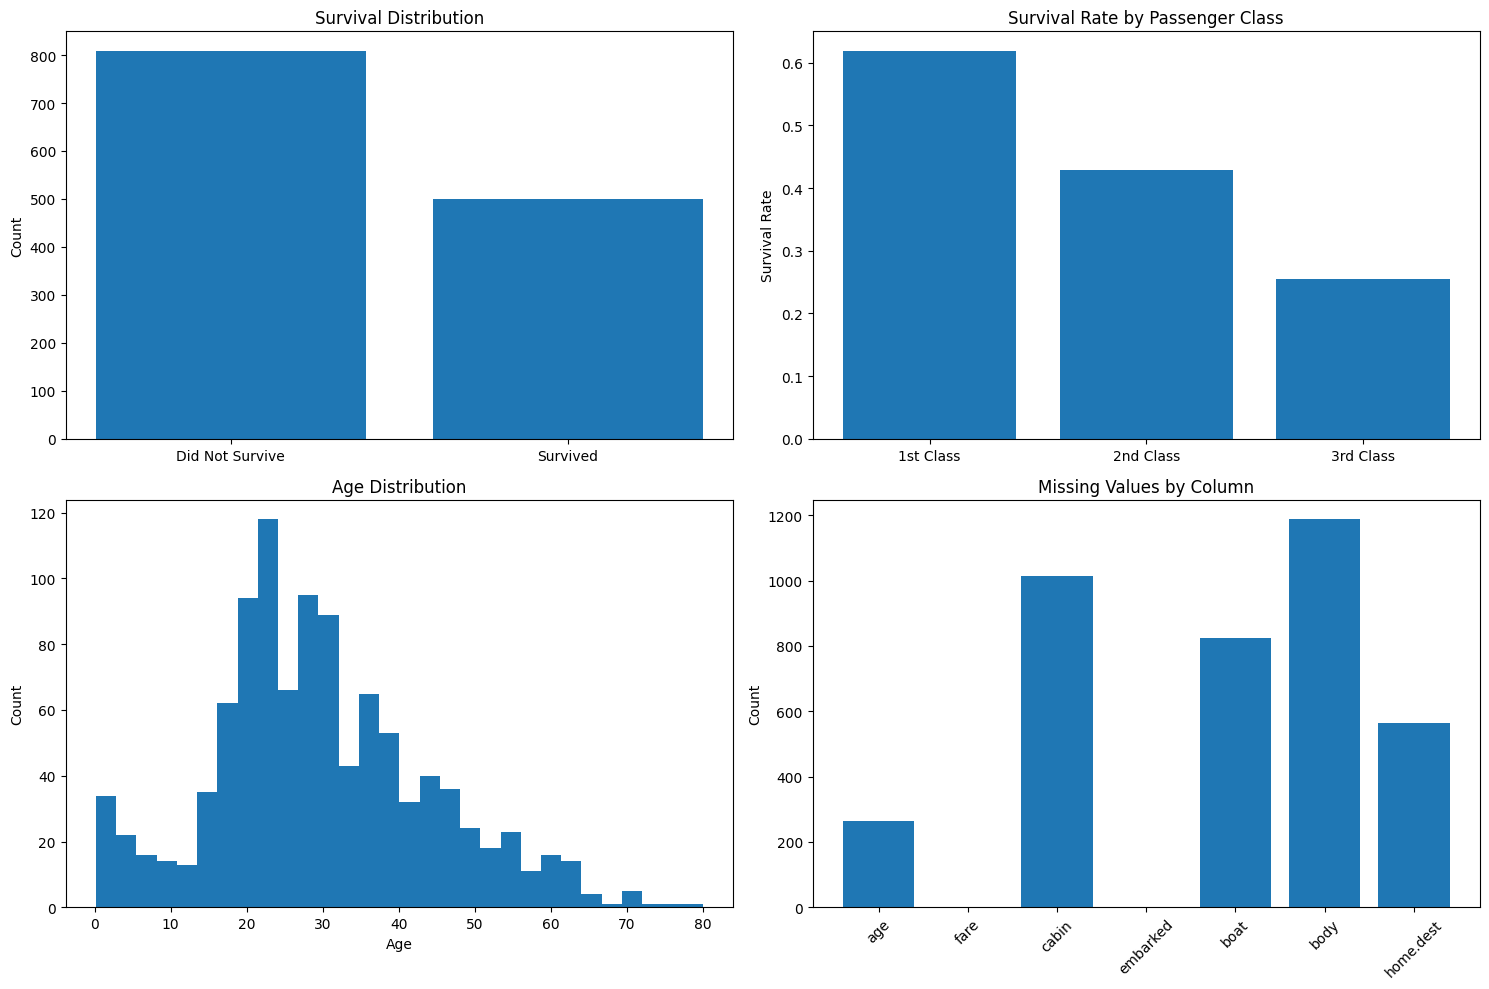

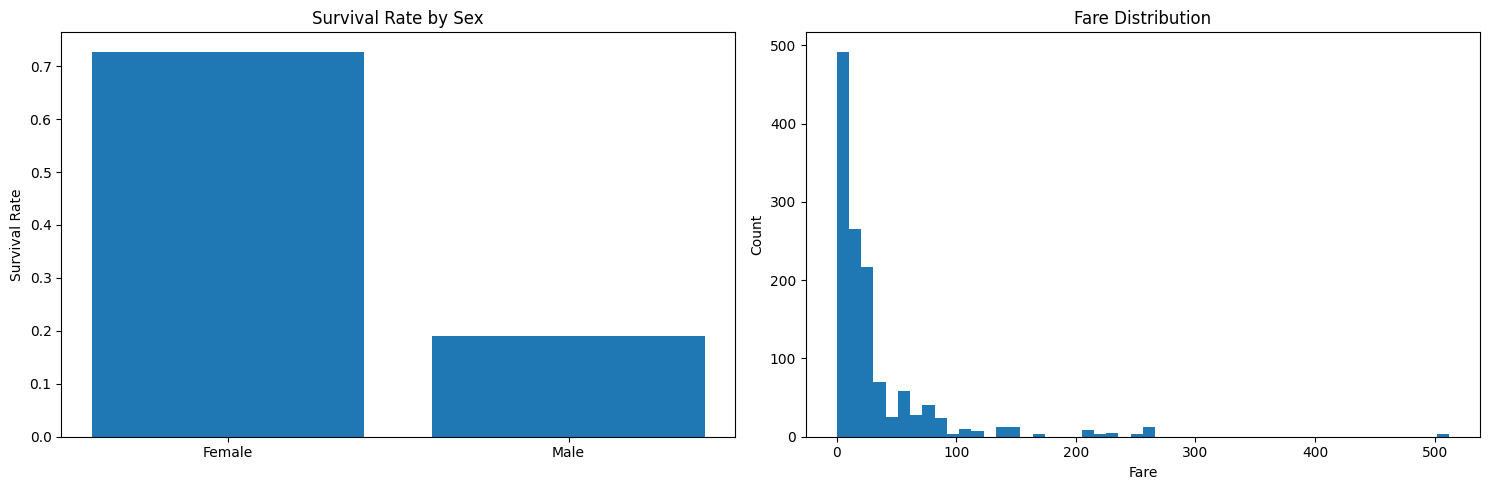

In [12]:
# Task 1:

plt.figure(figsize=(15, 10))

# 1. Survival Distribution
plt.subplot(2, 2, 1)
survival_counts = df['survived'].value_counts()
plt.bar(['Did Not Survive', 'Survived'], [survival_counts[0], survival_counts[1]])
plt.title('Survival Distribution')
plt.ylabel('Count')

# 2. Survival by Passenger Class
plt.subplot(2, 2, 2)
survival_by_class = df.groupby('pclass')['survived'].mean()
plt.bar(['1st Class', '2nd Class', '3rd Class'], survival_by_class)
plt.title('Survival Rate by Passenger Class')
plt.ylabel('Survival Rate')

# 3. Age Distribution
plt.subplot(2, 2, 3)
plt.hist(df['age'].dropna(), bins=30)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')

# 4. Missing Values
plt.subplot(2, 2, 4)
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
plt.bar(range(len(missing_values)), missing_values.values)
plt.xticks(range(len(missing_values)), missing_values.index, rotation=45)
plt.title('Missing Values by Column')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))

# 1. Survival by Sex
plt.subplot(1, 2, 1)
survival_by_sex = df.groupby('sex')['survived'].mean()
plt.bar(['Female', 'Male'], survival_by_sex)
plt.title('Survival Rate by Sex')
plt.ylabel('Survival Rate')

# 2. Fare Distribution
plt.subplot(1, 2, 2)
plt.hist(df['fare'].dropna(), bins=50)
plt.title('Fare Distribution')
plt.xlabel('Fare')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [55]:
#Task 2:

df_clean = df.copy()

# 1. Handle 'embarked':
# Strategy: Fill with most common port
most_common_port = df_clean['embarked'].mode()[0]
df_clean['embarked'] = df_clean['embarked'].fillna(most_common_port)

# 2. Handle 'age':
# Strategy: Convert age to numeric values and fill missing age values with median age
median_age = df_clean['age'].median()
df_clean['age'] = df_clean['age'].fillna(median_age)
# Converting age to numeric
df_final['age'] = pd.to_numeric(df_final['age'], errors='coerce')

# Also, it looks like 'name' appears twice in your dataframe
# Let's drop duplicate columns
df_final = df_final.loc[:,~df_final.columns.duplicated()]

print("\nColumns after removing duplicates:")
print(df_final.columns.tolist())

# 3. Handle 'cabin'
# Strategy: Create deck feature from first letter, then drop cabin
df_clean['deck'] = df_clean['cabin'].str[0]
df_clean['deck'] = df_clean['deck'].fillna('Unknown')

# 4. Handle 'fare':
median_fares = df_clean.groupby('pclass')['fare'].median()
for pclass, median_fare in median_fares.items():
    mask = df_clean['pclass'] == pclass
    df_clean.loc[mask, 'fare'] = df_clean.loc[mask, 'fare'].fillna(median_fare)

# 5. Create family features
df_clean['family_size'] = df_clean['sibsp'] + df_clean['parch'] + 1
df_clean['is_alone'] = (df_clean['family_size'] == 1).astype(int)

# 6. Droping columns that aren't needed for prediction
columns_to_drop = ['ticket', 'cabin', 'boat', 'body', 'home.dest', 'sibsp', 'parch']
df_clean = df_clean.drop(columns=columns_to_drop)

print("\nFinal columns after Task 2:")
print(df_clean.columns.tolist())



Data types after conversion:
survived          int64
name             object
age             float64
fare            float64
family_size       int64
is_alone          int64
pclass_1        float64
pclass_2        float64
pclass_3        float64
sex_female      float64
sex_male        float64
embarked_C      float64
embarked_Q      float64
embarked_S      float64
deck_A          float64
deck_B          float64
deck_C          float64
deck_D          float64
deck_E          float64
deck_F          float64
deck_G          float64
deck_T          float64
deck_Unknown    float64
dtype: object

Columns after removing duplicates:
['survived', 'name', 'age', 'fare', 'family_size', 'is_alone', 'pclass_1', 'pclass_2', 'pclass_3', 'sex_female', 'sex_male', 'embarked_C', 'embarked_Q', 'embarked_S', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G', 'deck_T', 'deck_Unknown']

Final columns after Task 2:
['pclass', 'survived', 'name', 'sex', 'age', 'fare', 'embarked', 'deck', 'fa

In [62]:
# Task 3: 

# Categorical features identified after task 2
categorical_features = ['pclass', 'sex', 'embarked', 'deck']

encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = encoder.fit_transform(df_clean[categorical_features])

# Getting feature names for encoded columns
feature_names = []
for i, feature in enumerate(categorical_features):
    categories = encoder.categories_[i][1:]  
    feature_names.extend([f"{feature}_{cat}" for cat in categories])

# Creating a DataFrame with encoded features
encoded_df = pd.DataFrame(
    encoded_features, 
    columns=feature_names,
    index=df_clean.index
)

# Combining with non-categorical columns
df_encoded = pd.concat([
    df_clean[['survived', 'name', 'age', 'fare', 'family_size', 'is_alone']], 
    encoded_df
], axis=1)

print("\nColumns after encoding:")
print(df_encoded.columns.tolist())


Columns after encoding:
['survived', 'name', 'age', 'fare', 'family_size', 'is_alone', 'pclass_2', 'pclass_3', 'sex_male', 'embarked_Q', 'embarked_S', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G', 'deck_T', 'deck_Unknown']


In [58]:
# Task 4: 
numerical_features = ['age', 'fare', 'family_size', 'is_alone']

# Creating copies for different scaling methods
df_standard = df_encoded.copy()
df_minmax = df_encoded.copy()

# StandardScaler for standardization of numerical features (mean=0, std=1)
scaler_standard = StandardScaler()
df_standard[numerical_features] = scaler_standard.fit_transform(df_standard[numerical_features])

# MinMaxScaler for normalization of numerical features (scale to [0,1])
scaler_minmax = MinMaxScaler()
df_minmax[numerical_features] = scaler_minmax.fit_transform(df_minmax[numerical_features])

print("\nSample of StandardScaler results:")
print(df_standard[numerical_features].head())
print("\nSample of MinMaxScaler results:")
print(df_minmax[numerical_features].head())


Sample of StandardScaler results:
        age      fare  family_size  is_alone
0 -0.039005  3.442540    -0.558346  0.810532
1 -2.215952  2.286641     1.336749 -1.233758
2 -2.131977  2.286641     1.336749 -1.233758
3  0.038512  2.286641     1.336749 -1.233758
4 -0.349075  2.286641     1.336749 -1.233758

Sample of MinMaxScaler results:
        age      fare  family_size  is_alone
0  0.361169  0.412503          0.0       1.0
1  0.009395  0.295806          0.3       0.0
2  0.022964  0.295806          0.3       0.0
3  0.373695  0.295806          0.3       0.0
4  0.311064  0.295806          0.3       0.0


In [70]:
# Task 5: Data Splitting
from sklearn.model_selection import train_test_split

# Separate test set
X = df_encoded.drop('survived', axis=1)  # Features
y = df_encoded['survived']               # Target (whether person survived or did not survive)

# First split: divinding data into training (%80) + validation (%20)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 8)

# Second split: dividing training (%75) + validation (%25)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state = 8)

print("Training distribution:\n", y_train.value_counts(normalize=True))
print("Validation distribution:\n", y_val.value_counts(normalize=True))
print("Test distribution:\n", y_test.value_counts(normalize=True))


Training distribution:
 survived
0    0.617834
1    0.382166
Name: proportion, dtype: float64
Validation distribution:
 survived
0    0.618321
1    0.381679
Name: proportion, dtype: float64
Test distribution:
 survived
0    0.618321
1    0.381679
Name: proportion, dtype: float64


In [80]:
# Task 6:

from imblearn.over_sampling import SMOTE

# Checking imbalance
print("Imbalance in training data::")
print(y_train.value_counts())
print("Training set shape before SMOTE:", X_train_no_name.shape)

# Fixing the imbalance
X_train_no_name = X_train.drop('name', axis=1)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_no_name, y_train)

# Results after using SMOTE
print("Training set shape after SMOTE:", X_resampled.shape)
print("\nClass distribution after SMOTE:")
print(y_resampled.value_counts())

Imbalance in training data::
survived
0    485
1    300
Name: count, dtype: int64
Training set shape before SMOTE: (785, 17)
Training set shape after SMOTE: (970, 17)

Class distribution after SMOTE:
survived
0    485
1    485
Name: count, dtype: int64
